In [1]:
# Add the genderComputer library to the path
import os
import sys

path = os.path.join(os.getcwd(), 'vendor', 'genderComputer')
sys.path.insert(0, path)

In [2]:
# Infer the gender of the authors
import analyze_genders

df = analyze_genders.dataframe(field='DB')
aggregates = analyze_genders.aggregate_authorship(df)

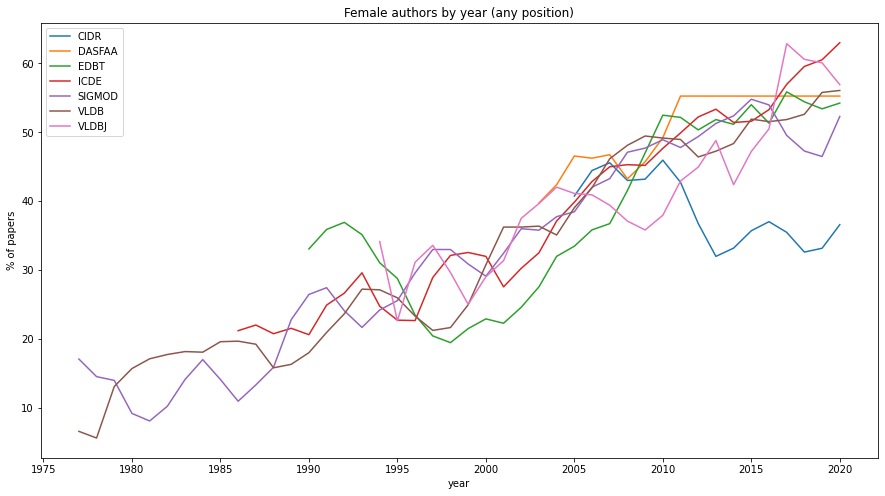

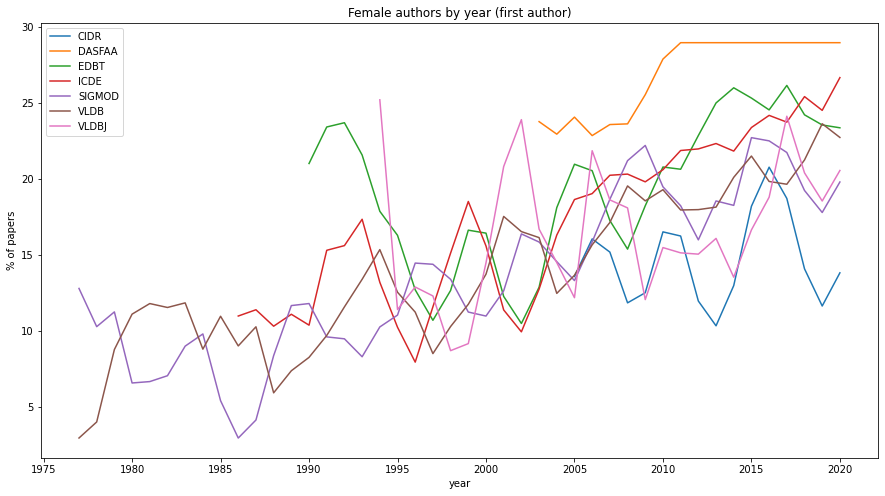

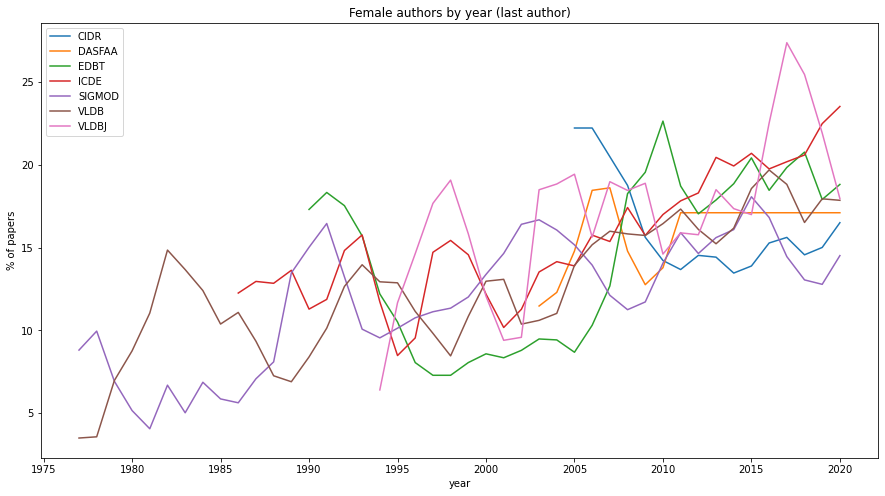

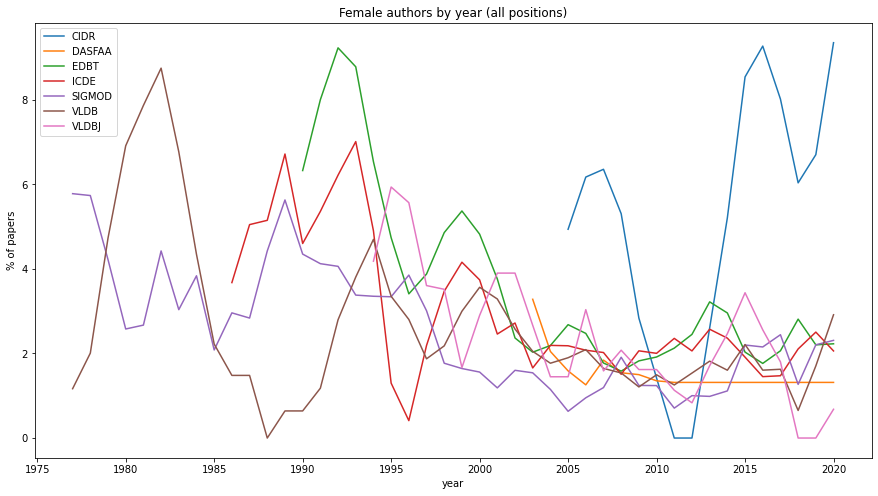

In [3]:
analyze_genders.plot_authors(aggregates['any'], 'any position')
analyze_genders.plot_authors(aggregates['first'], 'first author')
analyze_genders.plot_authors(aggregates['last'], 'last author')
analyze_genders.plot_authors(aggregates['all'], 'all positions')